## Data Cleaning

Load & Inspect the Dataset

In [2]:
import pandas as pd

# Load CSV
df = pd.read_csv("/content/historical_data.csv")

# Quick preview
print(df.head())
print(df.info())


   market_id           created_at actual_delivery_time  store_id  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:27:16      1845   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:56:29      5477   
2        3.0  2015-01-22 20:39:28  2015-01-22 21:09:09      5477   
3        3.0  2015-02-03 21:21:45  2015-02-03 22:13:00      5477   
4        3.0  2015-02-15 02:40:36  2015-02-15 03:20:26      5477   

  store_primary_category  order_protocol  total_items  subtotal  \
0               american             1.0            4      3441   
1                mexican             2.0            1      1900   
2                    NaN             1.0            1      1900   
3                    NaN             1.0            6      6900   
4                    NaN             1.0            3      3900   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1       

Convert Dates & Compute ETA

In [3]:
import numpy as np

# Convert to datetime
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# Compute delivery time in minutes
df['delivery_time_minutes'] = (df['actual_delivery_time'] - df['created_at']) / np.timedelta64(1, 'm')


Remove Outliers

In [4]:
# Keep only reasonable times (0 < ETA <= 180 mins)
df = df[(df['delivery_time_minutes'] > 0) & (df['delivery_time_minutes'] <= 180)]


 Check Missing Values

In [5]:
print(df.isnull().sum())

market_id                                         987
created_at                                          0
actual_delivery_time                                0
store_id                                            0
store_primary_category                           4759
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16248
total_busy_dashers                              16248
total_outstanding_orders                        16248
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
delivery_time_minutes                               0
dtype: int64


In [6]:
df = df.dropna()
print(df.isnull().sum())

market_id                                       0
created_at                                      0
actual_delivery_time                            0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
delivery_time_minutes                           0
dtype: int64


Pick Features

In [7]:
selected_columns = [
    'store_primary_category',    # categorical
    'order_protocol',            # categorical
    'total_items',               # numerical
    'subtotal',                  # numerical
    'num_distinct_items',        # numerical
    'min_item_price',            # numerical
    'max_item_price',            # numerical
    'total_onshift_dashers',     # numerical
    'total_busy_dashers',        # numerical
    'total_outstanding_orders',  # numerical
    'estimated_order_place_duration',       # numerical
    'estimated_store_to_consumer_driving_duration'  # numerical
]


In [8]:
target_column = 'delivery_time_minutes'


 Encode Categorical Variables

In [9]:
df_encoded = pd.get_dummies(df[selected_columns], columns=['store_primary_category', 'order_protocol'])

Define Features and Target

In [10]:
X = df_encoded.values.astype(np.float32)
y = df[target_column].values.astype(np.float32).reshape(-1, 1)  # shape (N, 1)

Normalize Features

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)


## Build Neural Network with PyTorch

Cuda

In [15]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


True
Tesla T4
Using device: cuda


Convert Data to PyTorch Tensors

In [16]:
from torch.utils.data import TensorDataset, DataLoader

X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


Define the Neural Network Architecture

In [19]:
import torch.nn as nn

class ETA_Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

model = ETA_Net(X.shape[1]).to(device)


Set the Loss Function and Optimizer

In [21]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Train the Model

In [23]:
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if epoch % 5 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch}, Loss: {running_loss:.4f}")



Epoch 0, Loss: 606667.0681
Epoch 5, Loss: 605672.1632
Epoch 10, Loss: 604738.3986
Epoch 15, Loss: 603712.2756
Epoch 20, Loss: 602834.3651
Epoch 25, Loss: 601850.2329
Epoch 30, Loss: 601494.0845
Epoch 35, Loss: 600919.1189
Epoch 40, Loss: 600087.5962
Epoch 45, Loss: 599279.9687
Epoch 50, Loss: 598539.2573
Epoch 55, Loss: 597926.8298
Epoch 60, Loss: 597865.4497
Epoch 65, Loss: 597034.5450
Epoch 70, Loss: 596311.6721
Epoch 75, Loss: 595673.0016
Epoch 80, Loss: 595392.2274
Epoch 85, Loss: 594825.4939
Epoch 90, Loss: 594867.3303
Epoch 95, Loss: 594246.9698
Epoch 99, Loss: 593719.9747


 Prediction & Evaluation & Visualization

In [24]:
model.eval()

with torch.no_grad():
    y_pred = model(X_tensor).cpu().numpy()
    y_true = y_tensor.cpu().numpy()


In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f} minutes")
print(f"RMSE: {rmse:.2f} minutes")
print(f"R² Score: {r2:.4f}")


MAE: 10.84 minutes
RMSE: 14.67 minutes
R² Score: 0.3376


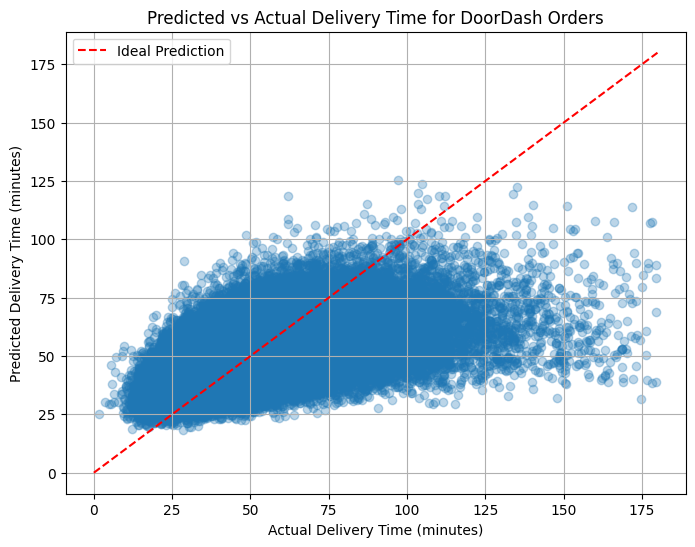

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.xlabel("Actual Delivery Time (minutes)")
plt.ylabel("Predicted Delivery Time (minutes)")
plt.title("Predicted vs Actual Delivery Time for DoorDash Orders")
plt.plot([0, 180], [0, 180], 'r--', label="Ideal Prediction")
plt.legend()
plt.grid(True)
plt.show()


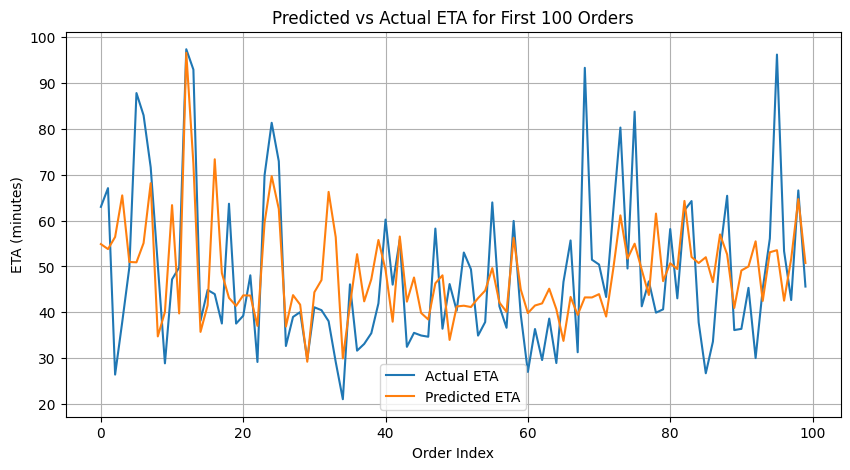

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(y_true[:100], label="Actual ETA")
plt.plot(y_pred[:100], label="Predicted ETA")
plt.xlabel("Order Index")
plt.ylabel("ETA (minutes)")
plt.title("Predicted vs Actual ETA for First 100 Orders")
plt.legend()
plt.grid(True)
plt.show()


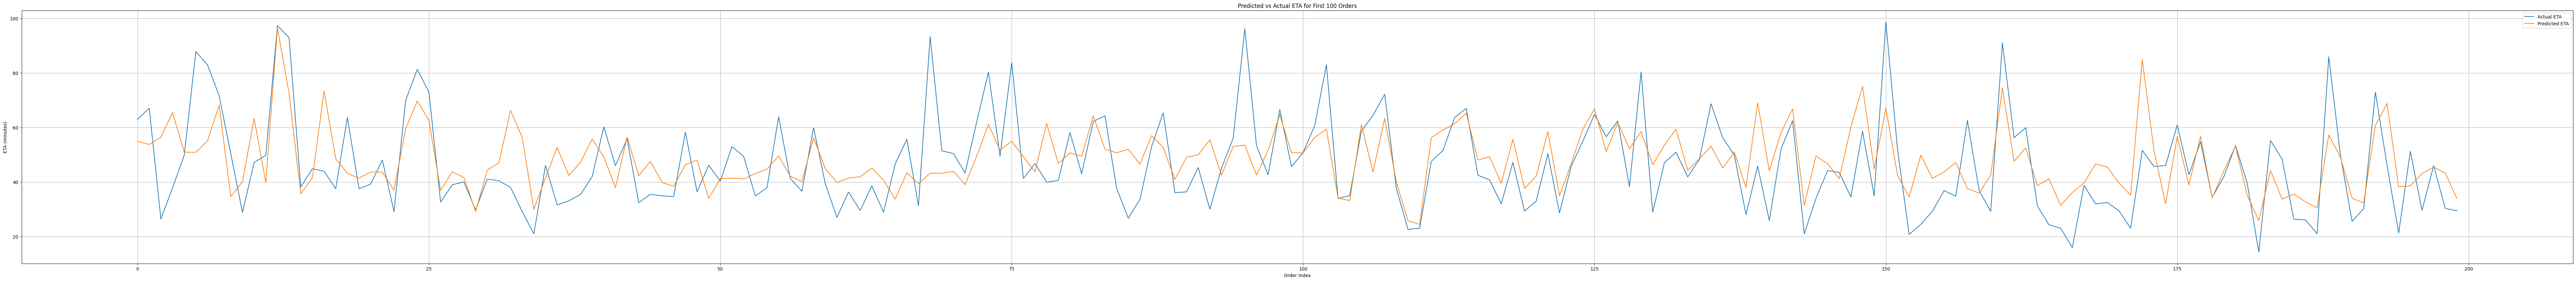

In [45]:
plt.figure(figsize=(100, 10))
plt.plot(y_true[:200], label="Actual ETA")
plt.plot(y_pred[:200], label="Predicted ETA")
plt.xlabel("Order Index")
plt.ylabel("ETA (minutes)")
plt.title("Predicted vs Actual ETA for First 100 Orders")
plt.legend()
plt.grid(True)
plt.show()

In [52]:
!pip install captum --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [54]:
from captum.attr import IntegratedGradients
import torch

model = model.to(device).eval()


In [ ]:
X_attr = X_tensor.to(device)
ig = IntegratedGradients(model)

In [59]:

baseline = torch.zeros_like(X_attr).to(device)

attributions, delta = ig.attribute(X_attr, baselines=baseline, return_convergence_delta=True)

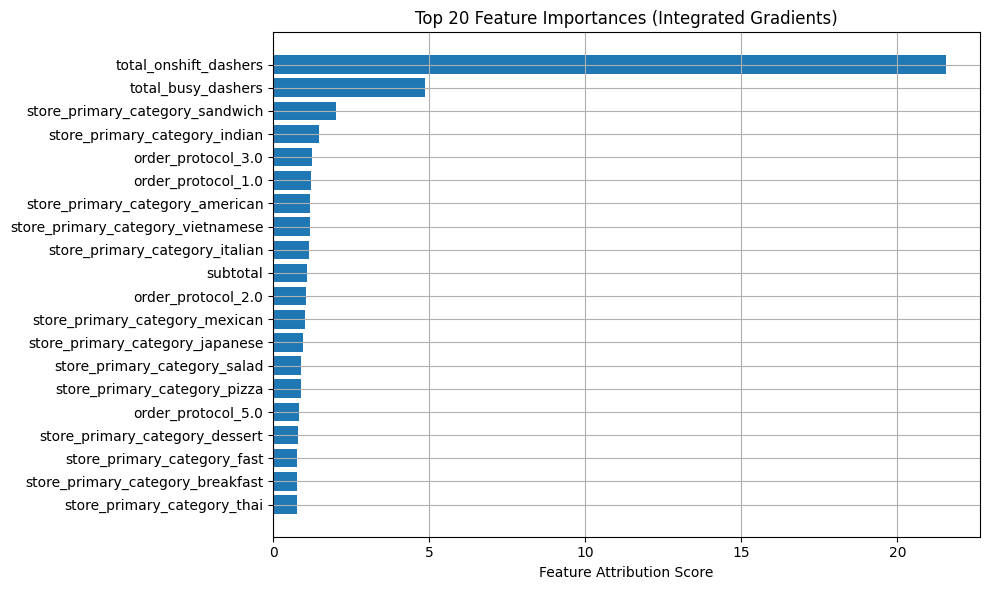

In [60]:
import matplotlib.pyplot as plt
import numpy as np

mean_attr = attributions.mean(dim=0).cpu().detach().numpy()
feature_names = df_encoded.columns

sorted_idx = np.argsort(mean_attr)[::-1]
top_n = 20

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), mean_attr[sorted_idx[:top_n]][::-1])
plt.yticks(range(top_n), feature_names[sorted_idx[:top_n]][::-1])
plt.xlabel("Feature Attribution Score")
plt.title("Top 20 Feature Importances (Integrated Gradients)")
plt.grid(True)
plt.tight_layout()
plt.show()
